In [1]:
# ===========================
# 1. Load Swap Events Function
# ===========================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces
import gym
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from arch import arch_model
from pykalman import KalmanFilter
import ta  # Technical Analysis library
import tensorflow as tf
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, StopTrainingOnRewardThreshold
import torch
import logging

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


def load_events(file_path, scaling_factor=1):
    """
    Loads and cleans events data from CSV, handling Burn, Mint, and Swap events.

    Parameters:
    - file_path: String, path to the swap events CSV file.
    - scaling_factor: Float, factor to scale down large numerical values to prevent overflow.

    Returns:
    - df: DataFrame containing cleaned and feature-engineered swap events.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Events data loaded from {file_path}.")
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{file_path}' was not found in the specified directory.")

    # Convert 'timestamp' to datetime and set as index
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Ensure numeric fields are of the correct data type
    numeric_fields = ['amount0', 'amount1', 'sqrtPriceX96', 'liquidity', 'tick', 'price_wstETH_ETH', 'amount']
    for field in numeric_fields:
        df[field] = pd.to_numeric(df[field], errors='coerce')

    # Backfill anomalies in 'price_wstETH_ETH' and 'sqrtPriceX96' using 3 standard deviations
    for column in ['price_wstETH_ETH', 'sqrtPriceX96']:
        if column in df.columns:
            mean = df[column].mean()
            std = df[column].std()
            df[column] = df[column].mask((df[column] < mean - 3 * std) | (df[column] > mean + 3 * std)).fillna(method='bfill')
            print(f"Backfilled anomalies in {column}.")
        else:
            print(f"Column '{column}' not found in data. Skipping backfill for this column.")

    # Compute fees (assuming amounts are in wei)
    FEE_RATE = 0.003  # 0.3%
    df['fee0'] = np.where(df['amount0'] > 0, df['amount0'] * FEE_RATE, 0)
    df['fee1'] = np.where(df['amount1'] > 0, df['amount1'] * FEE_RATE, 0)
    print("Fees computed.")

    # Handle event-specific fields
    # For Swap events, 'tickLower' and 'tickUpper' may be NaN
    # We'll create separate columns to track liquidity positions
    df['is_mint'] = df['event'] == 'Mint'
    df['is_burn'] = df['event'] == 'Burn'
    df['is_swap'] = df['event'] == 'Swap'

    # Calculate net liquidity changes
    df['net_liquidity_change'] = np.where(df['is_mint'], df['amount'],
                                          np.where(df['is_burn'], -df['amount'], 0.0))

    # Set missing 'tickLower' and 'tickUpper' to 0 for Swap events
    df['tickLower'] = df['tickLower'].fillna(0)
    df['tickUpper'] = df['tickUpper'].fillna(0)

    # Scale down large numerical values to prevent overflow
    df['amount0'] = df['amount0'] / scaling_factor
    df['amount1'] = df['amount1'] / scaling_factor
    df['sqrtPriceX96'] = df['sqrtPriceX96'] / scaling_factor
    df['liquidity'] = df['liquidity'] / scaling_factor
    df['fee0'] = df['fee0'] / scaling_factor
    df['fee1'] = df['fee1'] / scaling_factor
    df['net_liquidity_change'] = df['net_liquidity_change'] / scaling_factor
    print(f"Scaled down numerical values by a factor of {scaling_factor}.")

    # Create additional features
    # 1. Cumulative liquidity
    df['cumulative_liquidity'] = df['net_liquidity_change'].cumsum()

    # 2. Trading volume for Swap events
    df['swap_volume'] = np.where(df['is_swap'], np.abs(df['amount0']) + np.abs(df['amount1']), 0.0)

    # 3. Cumulative swap volume
    df['cumulative_swap_volume'] = df['swap_volume'].cumsum()

    # 4. Rolling window features (e.g., 30-day rolling volatility)
    df['returns'] = df['price_wstETH_ETH'].pct_change().fillna(0.0)
    df['volatility'] = df['returns'].rolling(window=30).std().fillna(0.0)

    # 5. Price momentum indicators
    df['price_ma_50'] = df['price_wstETH_ETH'].rolling(window=50).mean().fillna(method='bfill')
    df['price_ma_200'] = df['price_wstETH_ETH'].rolling(window=200).mean().fillna(method='bfill')

    # 6. Binary indicators for significant liquidity events
    df['is_large_mint'] = (df['is_mint']) & (df['net_liquidity_change'] > df['net_liquidity_change'].quantile(0.95))
    df['is_large_burn'] = (df['is_burn']) & (df['net_liquidity_change'] < df['net_liquidity_change'].quantile(0.05))

    # 7. Fill any remaining NaNs
    df = df.fillna(0.0)
    print("Additional features engineered and missing values filled.")

    return df

/Users/archev/Documents/GitHub/dynamic_model/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# ===========================
# 2. Load Macroeconomic Data Function
# ===========================

import os
import pandas as pd
import numpy as np

def load_macroeconomic_data(data_dir='data'):
    """
    Loads and merges macroeconomic data from CSV files.
    
    Parameters:
    - data_dir: String, directory where macroeconomic CSV files are stored.
    
    Returns:
    - macro_data_final: DataFrame containing merged and processed macroeconomic data.
    """
    # Define file paths
    fed_rate_path = os.path.join(data_dir, 'fed_rate.csv')
    treasury_yield_path = os.path.join(data_dir, 'treasuries.csv')
    sp500_path = os.path.join(data_dir, 'sp500.csv')
    stablecoins_path = os.path.join(data_dir, 'stablecoins.csv')
    vix_path = os.path.join(data_dir, 'vix.csv')
    
    # Initialize empty list to store individual DataFrames
    dfs = []
    
    # Load Effective Federal Funds Rate
    try:
        eff_fed_rate = pd.read_csv(fed_rate_path, parse_dates=['DATE'], index_col='DATE')
        eff_fed_rate.rename(columns={'EFFR': 'fed_rate'}, inplace=True)
        eff_fed_rate = eff_fed_rate.apply(pd.to_numeric, errors='coerce')
        eff_fed_rate.fillna(method='ffill', inplace=True)
        eff_fed_rate.fillna(method='bfill', inplace=True)
        print("Effective Federal Funds Rate data loaded successfully.")
        dfs.append(eff_fed_rate[['fed_rate']])
    except FileNotFoundError:
        raise FileNotFoundError(f"The file 'fed_rate.csv' was not found in the '{data_dir}' directory.")
    
    # Load 10-Year Treasury Yields
    try:
        treasury_yield = pd.read_csv(treasury_yield_path, parse_dates=['DATE'], index_col='DATE')
        treasury_yield.rename(columns={'DFII10': 'treasury_yield'}, inplace=True)
        treasury_yield = treasury_yield.apply(pd.to_numeric, errors='coerce')
        treasury_yield.fillna(method='ffill', inplace=True)
        treasury_yield.fillna(method='bfill', inplace=True)
        print("10-Year Treasury Yields data loaded successfully.")
        dfs.append(treasury_yield[['treasury_yield']])
    except FileNotFoundError:
        raise FileNotFoundError(f"The file 'treasuries.csv' was not found in the '{data_dir}' directory.")
    
    # Load S&P 500 Index
    try:
        sp500 = pd.read_csv(sp500_path, parse_dates=['DATE'], index_col='DATE')
        sp500.rename(columns={'SP500': 'sp500_index'}, inplace=True)
        sp500 = sp500.apply(pd.to_numeric, errors='coerce')
        sp500.fillna(method='ffill', inplace=True)
        sp500.fillna(method='bfill', inplace=True)
        print("S&P 500 Index data loaded successfully.")
        dfs.append(sp500[['sp500_index']])
    except FileNotFoundError:
        raise FileNotFoundError(f"The file 'sp500.csv' was not found in the '{data_dir}' directory.")
    
    # Load Stablecoin Market Capitalization
    try:
        stablecoins = pd.read_csv(stablecoins_path, parse_dates=['Date'])
        stablecoins['Timestamp'] = pd.to_datetime(stablecoins['Date'])
        stablecoins.set_index('Timestamp', inplace=True)
        stablecoins.rename(columns={'Total': 'stablecoin_mcap'}, inplace=True)
        stablecoins = stablecoins.apply(pd.to_numeric, errors='coerce')
        stablecoins.fillna(method='ffill', inplace=True)
        stablecoins.fillna(method='bfill', inplace=True)
        print("Stablecoin Market Capitalization data loaded successfully.")
        dfs.append(stablecoins[['stablecoin_mcap']])
    except FileNotFoundError:
        raise FileNotFoundError(f"The file 'stablecoins.csv' was not found in the '{data_dir}' directory.")
    
    # Load VIX Index
    try:
        vix = pd.read_csv(vix_path, parse_dates=['DATE'], index_col='DATE')
        vix.rename(columns={'VIXCLS': 'vix_index'}, inplace=True)
        vix = vix.apply(pd.to_numeric, errors='coerce')
        vix.fillna(method='ffill', inplace=True)
        vix.fillna(method='bfill', inplace=True)
        print("VIX Index data loaded successfully.")
        dfs.append(vix[['vix_index']])
    except FileNotFoundError:
        raise FileNotFoundError(f"The file 'vix.csv' was not found in the '{data_dir}' directory.")
    
    # Merge all macroeconomic data into a single DataFrame
    macro_data = pd.concat(dfs, axis=1)
    print("Macroeconomic data concatenated successfully.")
    
    # Resample to daily frequency and handle missing values
    macro_data = macro_data.resample('D').mean()
    macro_data = macro_data.apply(pd.to_numeric, errors='coerce')
    macro_data = macro_data.fillna(method='ffill').fillna(method='bfill')
    print("Macroeconomic data resampled to daily frequency and missing values filled.")
    
    # Feature Engineering
    # 1. Rate of Change for Federal Funds Rate
    macro_data['fed_rate_change'] = macro_data['fed_rate'].pct_change().fillna(0.0)
    macro_data['vix_change'] = macro_data['vix_index'].pct_change().fillna(0.0)
    
    # 2. Moving Averages
    macro_data['treasury_yield_ma_30'] = macro_data['treasury_yield'].rolling(window=30).mean().fillna(method='bfill')
    macro_data['sp500_index_ma_30'] = macro_data['sp500_index'].rolling(window=30).mean().fillna(method='bfill')
    macro_data['vix_index_ma_30'] = macro_data['vix_index'].rolling(window=30).mean().fillna(method='bfill')
    # 3. Volatility Indicators
    macro_data['sp500_volatility'] = macro_data['sp500_index'].rolling(window=30).std().fillna(0.0)
    
    # 4. Interaction Features
    macro_data['fed_treasury_yield_ratio'] = macro_data['fed_rate'] / macro_data['treasury_yield']
    
    # 5. Normalize Macro Features (Optional)
    macro_features = ['fed_rate', 'treasury_yield', 'sp500_index', 'stablecoin_mcap',
                      'fed_rate_change', 'treasury_yield_ma_30', 'sp500_index_ma_30',
                      'sp500_volatility']
    
    for feature in macro_features:
        mean = macro_data[feature].mean()
        std = macro_data[feature].std()
        if std != 0:
            macro_data[feature + '_zscore'] = (macro_data[feature] - mean) / std
        else:
            macro_data[feature + '_zscore'] = 0.0
        print(f"Normalized {feature} using z-score.")
    
    
    return macro_data

In [3]:
# ===========================
# 3. Event Data Integration
# ===========================

def integrate_event_data(merged_df):
    """
    Integrates event data into the merged DataFrame.

    Parameters:
    - merged_df: DataFrame, merged swap events and macroeconomic data

    Returns:
    - merged_df: DataFrame with event indicators
    """
    # Define threshold changes for event detection
    fed_rate_threshold = 0.25  # 25 basis points
    treasury_yield_threshold = 0.10  # 10 basis points
    sp500_threshold = 0.02  # 2% change
    stablecoin_mcap_threshold = 0.05  # 5% change

    merged_df['total_fee'] = merged_df['fee0'] + merged_df['fee1']
    
    # Indicator for presence of swap
    merged_df['has_swap'] = merged_df['is_swap'].astype(int)

    # Calculate daily changes
    merged_df['fed_rate_change'] = merged_df['fed_rate'].diff()
    merged_df['treasury_yield_change'] = merged_df['treasury_yield'].diff()
    merged_df['sp500_return'] = merged_df['sp500_index'].pct_change()
    merged_df['stablecoin_mcap_change'] = merged_df['stablecoin_mcap'].pct_change()

    # Create event indicators
    merged_df['event'] = 0
    merged_df.loc[merged_df['fed_rate_change'].abs() >= fed_rate_threshold, 'event'] = 1
    merged_df.loc[merged_df['treasury_yield_change'].abs() >= treasury_yield_threshold, 'event'] = 1
    merged_df.loc[merged_df['sp500_return'].abs() >= sp500_threshold, 'event'] = 1
    merged_df.loc[merged_df['stablecoin_mcap_change'].abs() >= stablecoin_mcap_threshold, 'event'] = 1
    print("\nEvent indicators created based on defined thresholds.")

    # Infer Rebasing Events from On-Chain Data
    merged_df['amount0_change'] = merged_df['amount0'].diff()

    # Define a threshold for detecting rebasing events (e.g., 3 standard deviations)
    rebasing_threshold = merged_df['amount0_change'].std() * 3
    merged_df['rebasing_event'] = 0
    merged_df.loc[merged_df['amount0_change'].abs() > rebasing_threshold, 'rebasing_event'] = 1
    print("Rebasing events inferred from On-Chain data.")

    return merged_df

In [4]:
# ===========================
# 5. Volatility and Data Modeling
# ===========================
from scipy.stats import norm

def calculate_volatility(merged_df):
    """
    Calculates volatility using EGARCH and smooths it with Kalman Filter.

    Parameters:
    - merged_df: DataFrame, merged swap events and macroeconomic data

    Returns:
    - merged_df: DataFrame with added 'volatility' and 'kalman_volatility' columns
    """
    # Calculate Log Returns
    merged_df['returns'] = np.log(merged_df['price_wstETH_ETH'] / merged_df['price_wstETH_ETH'].shift(1))
    merged_df.dropna(subset=['returns'], inplace=True)
    print("Log returns calculated.")

    # Fit Simplified EGARCH Model
    try:
        egarch_model = arch_model(merged_df['returns'], vol='EGARCH', p=1, o=0, q=1, dist='normal')
        egarch_results = egarch_model.fit(disp='off', update_freq=5)
        print("Simplified EGARCH model fitted successfully.")
    except Exception as e:
        raise ValueError(f"EGARCH model failed to converge even after simplifying: {e}")

    # Extract conditional volatility estimates
    merged_df['volatility'] = egarch_results.conditional_volatility

    # Check for any NaNs in volatility
    if merged_df['volatility'].isnull().any():
        raise ValueError("Volatility estimates contain NaNs. Please check the EGARCH model fitting.")

    print("Conditional volatility estimates extracted.")

    # Assuming normal distribution of returns
    confidence_level = 0.95
    z_score = norm.ppf(1 - confidence_level)
    merged_df['VaR'] = merged_df['volatility'] * z_score

    # Apply Kalman Filter for Volatility Smoothing
    observations = merged_df['volatility'].values

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=observations[0],
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.01
    )

    state_means, state_covariances = kf.filter(observations)
    merged_df['kalman_volatility'] = state_means.flatten()

    # Verify no NaNs in kalman_volatility
    if merged_df['kalman_volatility'].isnull().any():
        raise ValueError("Kalman-filtered volatility contains NaNs.")

    print("Kalman filter applied to volatility estimates.")

    return merged_df

In [5]:
def create_dpd(merged_df, frequency='D', lp_liquidity_fraction=1.0, zscore_window=30, fee_tier_fixed=0.003):
    """
    Creates the dpd DataFrame by aggregating swap events into specified frequency buckets using ETH values
    and adding technical indicators along with z-scores for macroeconomic features.

    Parameters:
    - merged_df: DataFrame, merged swap events and macroeconomic data
    - frequency: String, resampling frequency (e.g., 'H' for hourly, 'D' for daily)
    - lp_liquidity_fraction: Float, fraction of total liquidity provided by the LP (0 < fraction <= 1)
    - zscore_window: Int, window size for rolling z-score calculations
    - fee_tier_fixed: Float, fixed fee tier for passive strategy (e.g., 0.003 for 0.3%)

    Returns:
    - dpd: DataFrame containing aggregated pool data with technical indicators and z-scores
    """
    # Configure logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # Ensure 'lstm_predicted_price' is filled
    if 'lstm_predicted_price' not in merged_df.columns:
        if 'price_wstETH_ETH' in merged_df.columns:
            merged_df['lstm_predicted_price'] = merged_df['price_wstETH_ETH']
            logging.info("'lstm_predicted_price' column not found. Filled with 'price_wstETH_ETH'.")
        else:
            logging.error("'price_wstETH_ETH' column not found. Cannot fill 'lstm_predicted_price'.")
            raise KeyError("'price_wstETH_ETH' column not found in merged_df to fill 'lstm_predicted_price'.")
    merged_df['lstm_predicted_price'].fillna(method='ffill', inplace=True)

    # Check if necessary columns exist
    required_columns = ['price_wstETH_ETH', 'volatility']
    missing_columns = [col for col in required_columns if col not in merged_df.columns]
    if missing_columns:
        logging.error(f"Column(s) {missing_columns} do not exist in merged_df")
        raise KeyError(f"Column(s) {missing_columns} do not exist in merged_df")

    # List of z-score columns to include
    zscore_columns = [
        'fed_rate_zscore', 'treasury_yield_zscore', 'sp500_index_zscore',
        'stablecoin_mcap_zscore', 'fed_rate_change_zscore',
        'treasury_yield_ma_30_zscore', 'sp500_index_ma_30_zscore',
        'sp500_volatility_zscore'
    ]

    # Verify that all z-score columns exist in merged_df
    missing_zscore_columns = [col for col in zscore_columns if col not in merged_df.columns]
    if missing_zscore_columns:
        logging.error(f"Z-Score columns {missing_zscore_columns} are missing in merged_df")
        raise KeyError(f"Z-Score columns {missing_zscore_columns} are missing in merged_df")

    # Derive 'amount_in' based on event type
    merged_df['amount_in'] = np.where(
        merged_df['is_swap'],
        merged_df[['amount0', 'amount1']].apply(lambda row: max(row['amount0'], 0) + max(row['amount1'], 0), axis=1),
        0.0
    )

    # Resample to the specified frequency, including z-score columns and 'amount_in'
    try:
        aggregation_dict = {
            'liquidity': 'last',
            'price_wstETH_ETH': ['last', 'max', 'min'],
            'fee0': 'sum',
            'fee1': 'sum',
            'lstm_predicted_price': 'last',
            # 'transformer_predicted_price': 'last',
            'volatility': 'last',
            'kalman_volatility': 'last',
            'tick': 'last',
            'cumulative_liquidity': 'last',
            'amount_in': 'sum',
            'VaR': 'last',
            'vix_index': 'last',
        }

        # Add z-score columns to the aggregation dictionary with 'last' as the aggregation method
        for zcol in zscore_columns:
            aggregation_dict[zcol] = 'last'

        dpd = merged_df.resample(frequency).agg(aggregation_dict)
    except Exception as e:
        logging.error(f"Error during resampling: {e}")
        raise e

    # Flatten MultiIndex columns
    dpd.columns = [
        'liquidity', 'close', 'high', 'low',
        'fee0_total', 'fee1_total',
        'lstm_predicted_price', 'volatility', 'kalman_volatility',
        'tick', 'cumulative_liquidity',
        'amount_in', 'VaR', 'vix_index'
    ] + zscore_columns

    # Replace zero 'close' prices to avoid division by zero
    dpd['close'].replace(0, np.nan, inplace=True)
    dpd['close'].fillna(method='ffill', inplace=True)
    dpd['close'].fillna(method='bfill', inplace=True)

    # Calculate ETH_price as the inverse of close price
    with np.errstate(divide='ignore'):
        dpd['ETH_price'] = 1 / dpd['close']
    dpd['ETH_price'].replace([np.inf, -np.inf], np.nan, inplace=True)
    dpd['ETH_price'].fillna(method='ffill', inplace=True)
    dpd['ETH_price'].fillna(method='bfill', inplace=True)

    # Handle any remaining NaNs and infinities
    dpd.replace([np.inf, -np.inf], np.nan, inplace=True)
    dpd.fillna(method='ffill', inplace=True)
    dpd.fillna(method='bfill', inplace=True)

    # Calculate the percentage change for 'liquidity'
    dpd['liquidity_pct_change'] = dpd['liquidity'].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

    # Calculate LP's share of the liquidity
    dpd['LP_liquidity_ETH'] = dpd['liquidity'] * lp_liquidity_fraction

    # Calculate LP's accumulated fees
    dpd['accumulated_fee0'] = dpd['fee0_total'] * lp_liquidity_fraction  # Already in ETH units
    dpd['accumulated_fee1'] = dpd['fee1_total'] * lp_liquidity_fraction  # Already in ETH units

    # Replace negative fees with zero (if any)
    dpd['accumulated_fee0'] = dpd['accumulated_fee0'].clip(lower=0)
    dpd['accumulated_fee1'] = dpd['accumulated_fee1'].clip(lower=0)

    # Sum accumulated fees
    dpd['adjusted_fee'] = dpd['accumulated_fee0'] + dpd['accumulated_fee1']

    # Calculate Active Liquidity (LP's liquidity)
    dpd['ActiveLiq'] = dpd['LP_liquidity_ETH']  # LP's liquidity in ETH

    # ===============================
    # Adding Technical Indicators
    # ===============================

    # Moving Averages
    dpd['MA_10'] = dpd['close'].rolling(window=10, min_periods=1).mean()
    dpd['MA_50'] = dpd['close'].rolling(window=50, min_periods=1).mean()
    dpd['MA_200'] = dpd['close'].rolling(window=200, min_periods=1).mean()

    # Relative Strength Index (RSI)
    rsi = ta.momentum.RSIIndicator(close=dpd['close'], window=14)
    dpd['RSI'] = rsi.rsi()
    dpd['RSI'].fillna(method='ffill', inplace=True)
    dpd['RSI'].fillna(method='bfill', inplace=True)

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=dpd['close'], window=20, window_dev=2)
    dpd['BB_upper'] = bollinger.bollinger_hband()
    dpd['BB_lower'] = bollinger.bollinger_lband()
    dpd['BB_upper'].fillna(method='ffill', inplace=True)
    dpd['BB_upper'].fillna(method='bfill', inplace=True)
    dpd['BB_lower'].fillna(method='ffill', inplace=True)
    dpd['BB_lower'].fillna(method='bfill', inplace=True)

    # ===============================
    # Adding 'fee_tier' Column
    # ===============================

    # For Passive Strategy: Set 'fee_tier' to a fixed value (e.g., 0.003 for 0.3%)
    dpd['fee_tier'] = fee_tier_fixed

    # ===============================
    # Final Data Integrity Checks
    # ===============================

    # Ensure all required z-score columns are present
    final_zscore_columns = zscore_columns  # These are already z-scores

    # Verify that all z-score columns are present
    missing_final_zscore_columns = [col for col in final_zscore_columns if col not in dpd.columns]
    if missing_final_zscore_columns:
        logging.error(f"Z-Score columns {missing_final_zscore_columns} are missing in dpd")
        raise KeyError(f"Z-Score columns {missing_final_zscore_columns} are missing in dpd")

    # Handle any remaining NaNs after technical indicators and 'fee_tier' addition
    dpd.fillna(method='ffill', inplace=True)
    dpd.fillna(method='bfill', inplace=True)

    # Logging the successful creation of dpd
    logging.info(f"dpd DataFrame created with Active Liquidity, ETH_price, volatility, liquidity_pct_change, accumulated fees, technical indicators, and fee_tier at {frequency} frequency.")

    return dpd

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def build_and_train_lstm(dpd, lstm_model_path='lstm_model.keras', look_back=60):
    """
    Builds and trains an improved LSTM model to predict future prices.

    Parameters:
    - dpd: DataFrame, processed dpd data
    - lstm_model_path: String, path to save the trained LSTM model
    - look_back: Integer, number of past timesteps to use for prediction

    Returns:
    - model: Trained LSTM model
    - dpd: DataFrame, updated with predictions
    """
    # Select features to use as input
    features = ['close', 'volatility', 'MA_10', 'MA_50', 'RSI', 'BB_upper', 'BB_lower', 'amount_in', 'fee_tier', 'liquidity', 'VaR', 'vix_index']
    target = 'close'

    # Drop any rows with NaN values in selected features
    dpd = dpd.dropna(subset=features)

    # Convert the DataFrame to numpy array
    dataset = dpd[features].values.astype('float32')

    # Normalize the features
    scaler = StandardScaler()
    dataset_scaled = scaler.fit_transform(dataset)

    # Split into train, validation, and test sets
    train_size = int(len(dataset_scaled) * 0.7)
    val_size = int(len(dataset_scaled) * 0.15)
    test_size = len(dataset_scaled) - train_size - val_size

    train, val, test = dataset_scaled[:train_size], dataset_scaled[train_size:train_size+val_size], dataset_scaled[train_size+val_size:]

    # Function to create dataset
    def create_dataset(data, look_back=1):
        X, Y = [], []
        for i in range(len(data)-look_back):
            X.append(data[i:(i+look_back), :])
            Y.append(data[i + look_back, features.index(target)])  # Index of 'close' in features
        return np.array(X), np.array(Y)

    # Create datasets
    X_train, Y_train = create_dataset(train, look_back)
    X_val, Y_val = create_dataset(val, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(look_back, len(features))))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=64, epochs=100, callbacks=[early_stop], verbose=1)

    # Save the model
    model.save(lstm_model_path)
    print(f"LSTM model trained and saved to {lstm_model_path}.")

    # Evaluate the model
    train_predict = model.predict(X_train)
    val_predict = model.predict(X_val)
    test_predict = model.predict(X_test)

    # Invert scaling for predictions
    def invert_scaling(X, y_pred):
        y_pred_full = np.zeros((y_pred.shape[0], dataset.shape[1]))
        y_pred_full[:, features.index(target)] = y_pred.flatten()
        X_last = X[:, -1, :]
        y_pred_full[:, [i for i in range(dataset.shape[1]) if i != features.index(target)]] = X_last[:, [i for i in range(dataset.shape[1]) if i != features.index(target)]]
        y_pred_inv = scaler.inverse_transform(y_pred_full)[:, features.index(target)]
        return y_pred_inv

    Y_train_inv = dpd[target].values[look_back:train_size]
    Y_val_inv = dpd[target].values[train_size+look_back:train_size+val_size]
    Y_test_inv = dpd[target].values[train_size+val_size+look_back:]

    train_predict_inv = invert_scaling(X_train, train_predict)
    val_predict_inv = invert_scaling(X_val, val_predict)
    test_predict_inv = invert_scaling(X_test, test_predict)

    # Calculate RMSE and MAE
    train_rmse = sqrt(mean_squared_error(Y_train_inv, train_predict_inv))
    train_mae = mean_absolute_error(Y_train_inv, train_predict_inv)
    val_rmse = sqrt(mean_squared_error(Y_val_inv, val_predict_inv))
    val_mae = mean_absolute_error(Y_val_inv, val_predict_inv)
    test_rmse = sqrt(mean_squared_error(Y_test_inv, test_predict_inv))
    test_mae = mean_absolute_error(Y_test_inv, test_predict_inv)

    print(f"Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

    # Add predictions to dpd
    dpd['lstm_predicted_price'] = np.nan

    dpd_indices = dpd.index

    # For train predictions
    train_indices = dpd_indices[look_back:train_size]
    dpd.loc[train_indices, 'lstm_predicted_price'] = train_predict_inv

    # For validation predictions
    val_indices = dpd_indices[train_size+look_back:train_size+val_size]
    dpd.loc[val_indices, 'lstm_predicted_price'] = val_predict_inv

    # For test predictions
    test_indices = dpd_indices[train_size+val_size+look_back:]
    dpd.loc[test_indices, 'lstm_predicted_price'] = test_predict_inv

    # Fill any remaining NaNs
    dpd['lstm_predicted_price'].fillna(method='ffill', inplace=True)
    dpd['lstm_predicted_price'].fillna(method='bfill', inplace=True)

    return model, dpd

In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

def build_and_train_transformer(dpd, transformer_model_path='transformer_model.h5', look_back=60):
    """
    Builds and trains a Transformer-based model to predict future prices.

    Parameters:
    - dpd: DataFrame, processed dpd data
    - transformer_model_path: String, path to save the trained model
    - look_back: Integer, number of past timesteps to use for prediction

    Returns:
    - model: Trained Transformer model
    - dpd: DataFrame, updated with predictions
    """
    from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
    from tensorflow.keras.models import Model

    # Select features to use as input
    features = ['close', 'volatility', 'MA_10', 'MA_50', 'RSI', 'BB_upper', 'BB_lower',
                'amount_in', 'fee_tier', 'liquidity', 'VaR', 'vix_index']
    target = 'close'

    # Drop any rows with NaN values in selected features
    dpd = dpd.dropna(subset=features)

    # Convert the DataFrame to numpy array
    dataset = dpd[features].values.astype('float32')

    # Normalize the features
    scaler = StandardScaler()
    dataset_scaled = scaler.fit_transform(dataset)

    # Split into train, validation, and test sets
    train_size = int(len(dataset_scaled) * 0.7)
    val_size = int(len(dataset_scaled) * 0.15)
    test_size = len(dataset_scaled) - train_size - val_size

    train, val, test = dataset_scaled[:train_size], dataset_scaled[train_size:train_size+val_size], dataset_scaled[train_size+val_size:]

    # Function to create dataset
    def create_dataset(data, look_back=1):
        X, Y = [], []
        for i in range(len(data)-look_back):
            X.append(data[i:(i+look_back), :])
            Y.append(data[i + look_back, features.index(target)])  # Index of 'close' in features
        return np.array(X), np.array(Y)

    # Create datasets
    X_train, Y_train = create_dataset(train, look_back)
    X_val, Y_val = create_dataset(val, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Build Transformer model
    input_shape = (look_back, len(features))
    inputs = Input(shape=input_shape)

    x = inputs
    x = LayerNormalization(epsilon=1e-6)(x)

    # Multi-Head Attention with compatible dimensions
    attention_output = MultiHeadAttention(num_heads=1, key_dim=11)(x, x)  # d_model=11
    attention_output = Dropout(0.1)(attention_output)
    x = attention_output + x  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Network with matching dimensions
    x_ffn = Dense(12, activation='relu')(x)
    x_ffn = Dense(12)(x_ffn)
    x = x_ffn + x  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=64, epochs=100, callbacks=[early_stop], verbose=1)

    # Save the model
    model.save(transformer_model_path)
    print(f"Transformer model trained and saved to {transformer_model_path}.")

    # Evaluate the model
    train_predict = model.predict(X_train)
    val_predict = model.predict(X_val)
    test_predict = model.predict(X_test)

    # Invert scaling for predictions
    def invert_scaling(X, y_pred):
        y_pred_full = np.zeros((y_pred.shape[0], dataset.shape[1]))
        y_pred_full[:, features.index(target)] = y_pred.flatten()
        X_last = X[:, -1, :]
        y_pred_full[:, [i for i in range(dataset.shape[1]) if i != features.index(target)]] = X_last[:, [i for i in range(dataset.shape[1]) if i != features.index(target)]]
        y_pred_inv = scaler.inverse_transform(y_pred_full)[:, features.index(target)]
        return y_pred_inv

    Y_train_inv = dpd[target].values[look_back:train_size]
    Y_val_inv = dpd[target].values[train_size+look_back:train_size+val_size]
    Y_test_inv = dpd[target].values[train_size+val_size+look_back:]

    train_predict_inv = invert_scaling(X_train, train_predict)
    val_predict_inv = invert_scaling(X_val, val_predict)
    test_predict_inv = invert_scaling(X_test, test_predict)

    # Calculate RMSE and MAE
    train_rmse = sqrt(mean_squared_error(Y_train_inv, train_predict_inv))
    train_mae = mean_absolute_error(Y_train_inv, train_predict_inv)
    val_rmse = sqrt(mean_squared_error(Y_val_inv, val_predict_inv))
    val_mae = mean_absolute_error(Y_val_inv, val_predict_inv)
    test_rmse = sqrt(mean_squared_error(Y_test_inv, test_predict_inv))
    test_mae = mean_absolute_error(Y_test_inv, test_predict_inv)

    print(f"Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}")

    # Add predictions to dpd
    dpd['lstm_predicted_price'] = np.nan

    dpd_indices = dpd.index

    # For train predictions
    train_indices = dpd_indices[look_back:train_size]
    dpd.loc[train_indices, 'lstm_predicted_price'] = train_predict_inv

    # For validation predictions
    val_indices = dpd_indices[train_size+look_back:train_size+val_size]
    dpd.loc[val_indices, 'lstm_predicted_price'] = val_predict_inv

    # For test predictions
    test_indices = dpd_indices[train_size+val_size+look_back:]
    dpd.loc[test_indices, 'lstm_predicted_price'] = test_predict_inv

    # Fill any remaining NaNs
    dpd['lstm_predicted_price'].fillna(method='ffill', inplace=True)
    dpd['lstm_predicted_price'].fillna(method='bfill', inplace=True)

    return model, dpd

In [8]:
# ===========================
# 7. Calculate Performance Metrics Function
# ===========================

import pandas as pd
import numpy as np

def calculate_performance(strategies, initial_capital, start_date, end_date):
    """
    Calculates performance metrics for each strategy.
    
    Args:
        strategies (dict): Dictionary containing strategies' DataFrames.
        initial_capital (float): Initial capital for the LP.
        start_date (pd.Timestamp): Start date of the backtest.
        end_date (pd.Timestamp): End date of the backtest.
        
    Returns:
        pd.DataFrame: DataFrame containing performance metrics for each strategy.
    """
    performance_metrics = {
        'Total Return': [],
        'Annualized Return': [],
        'Volatility': [],
        'Sharpe Ratio': [],
        'Max Drawdown': []
    }

    for strategy_name, df in strategies.items():
        # Ensure 'returns' column is numeric
        df['returns'] = pd.to_numeric(df['returns'], errors='coerce').fillna(0.0)

        # Calculate Total Return
        final_value = df['total_value'].iloc[-1]
        total_return = (final_value / initial_capital) - 1

        # Calculate Annualized Return
        days = (end_date - start_date).days
        if days > 0:
            annualized_return = (1 + total_return) ** (365 / days) - 1
        else:
            annualized_return = 0.0

        # Calculate Volatility (Standard Deviation of Returns)
        volatility = df['returns'].std() * np.sqrt(365)

        # Calculate Sharpe Ratio
        sharpe_ratio = (annualized_return) / volatility if volatility != 0 else np.nan

        # Calculate Max Drawdown
        cumulative_max = df['total_value'].cummax()
        drawdowns = (cumulative_max - df['total_value']) / cumulative_max
        max_drawdown = drawdowns.max()

        # Append metrics
        performance_metrics['Total Return'].append(total_return)
        performance_metrics['Annualized Return'].append(annualized_return)
        performance_metrics['Volatility'].append(volatility)
        performance_metrics['Sharpe Ratio'].append(sharpe_ratio)
        performance_metrics['Max Drawdown'].append(max_drawdown)

    metrics_df = pd.DataFrame(performance_metrics, index=strategies.keys())
    return metrics_df

In [9]:
# ===========================
# 8. Visualize Results Function
# ===========================

import matplotlib.pyplot as plt

def visualize_results(strategies):
    """
    Plots the portfolio value over time for each strategy.
    
    Args:
        strategies (dict): Dictionary containing strategies' DataFrames.
    """
    plt.figure(figsize=(12, 6))
    for strategy_name, df in strategies.items():
        plt.plot(df['total_value'], label=strategy_name)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
import logging
import numpy as np
import pandas as pd
import math

# ===================================
# Helper Functions for Passive LP
# ===================================

def tick_to_sqrt_price(tick: int) -> float:
    try:
        price = 1.0001 ** tick
        sqrt_price = math.sqrt(price)
        return sqrt_price
    except OverflowError:
        logging.error(f"Overflow error during tick to sqrt price conversion for tick: {tick}")
        return 0.0
    except Exception as e:
        logging.error(f"Error in tick_to_sqrt_price: {e}")
        return 0.0

def get_amounts_passive(sqrt_current: float, sqrtA: float, sqrtB: float, liquidity: float) -> tuple:
    try:
        if sqrt_current <= sqrtA:
            amount0 = liquidity * (sqrtB - sqrtA) / (sqrtB * sqrtA)
            amount1 = 0.0
        elif sqrtA < sqrt_current < sqrtB:
            amount0 = liquidity * (sqrtB - sqrt_current) / (sqrtB * sqrt_current)
            amount1 = liquidity * (sqrt_current - sqrtA)
        else:
            amount0 = 0.0
            amount1 = liquidity * (sqrtB - sqrtA)
    except Exception as e:
        logging.error(f"Error in get_amounts_passive: {e}")
        amount0, amount1 = 0.0, 0.0
    return amount0, amount1

def calculate_liquidity_passive(sqrt_current: float, sqrtA: float, sqrtB: float, amount0: float, amount1: float) -> float:
    try:
        if sqrt_current <= sqrtA:
            liquidity = amount0 * (sqrtB * sqrtA) / (sqrtB - sqrtA)
        elif sqrtA < sqrt_current < sqrtB:
            liquidity0 = amount0 * (sqrt_current * sqrtB) / (sqrtB - sqrt_current)
            liquidity1 = amount1 / (sqrt_current - sqrtA)
            liquidity = min(liquidity0, liquidity1)
        else:
            liquidity = amount1 * (sqrtB * sqrtA) / (sqrtB - sqrtA)
    except ZeroDivisionError:
        logging.error(f"ZeroDivisionError in calculate_liquidity_passive with amount0={amount0}, amount1={amount1}")
        liquidity = 0.0
    except Exception as e:
        logging.error(f"Error in calculate_liquidity_passive: {e}")
        liquidity = 0.0
    return liquidity

def generate_price_ranges(current_tick: int, tick_spacing: int, multipliers: list = [2, 5, 10]) -> list:
    price_ranges = []
    for multiplier in multipliers:
        range_width = tick_spacing * multiplier
        tick_lower = current_tick - range_width
        tick_upper = current_tick + range_width
        tick_lower = (tick_lower // tick_spacing) * tick_spacing
        tick_upper = (tick_upper // tick_spacing) * tick_spacing
        price_ranges.append((tick_lower, tick_upper))
    return price_ranges

def scale_dpd(dpd: pd.DataFrame) -> pd.DataFrame:
    dpd_scaled = dpd.copy()
    columns_to_scale = [
        'liquidity', 'cumulative_liquidity', 'amount_in',
        'accumulated_fee0', 'accumulated_fee1', 'LP_liquidity_ETH',
        'fee0_total', 'fee1_total', 'adjusted_fee'
    ]
    
    for col in columns_to_scale:
        if col in dpd_scaled.columns:
            dpd_scaled[col] = dpd_scaled[col] / 1e18
            logging.debug(f"Scaled column '{col}' to ETH.")
        else:
            logging.warning(f"Column '{col}' not found in DPD DataFrame. Skipping scaling for this column.")
    
    return dpd_scaled

In [11]:
def simulate_passive_lp(
    dpd: pd.DataFrame,
    initial_capital: float = 10.0,         # Adjusted for user example
    rebalance_frequency: int = 2000,       # Rebalancing every 2000 days (~5.48 years)
    fee_tier: float = 0.003,                # Fixed fee tier (e.g., 0.3%)
    allocation_fraction: float = 1.0,       # Allocation fraction set to 100%
    tick_spacing: int = 100,                # Tick spacing set to 100
) -> pd.DataFrame:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        handler = logging.StreamHandler()
        handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
        logger.addHandler(handler)
    
    # Initialize tracking DataFrame
    passive_df = pd.DataFrame(index=dpd.index, columns=['total_value', 'returns', 'fees_earned'])
    passive_df.iloc[0]['total_value'] = initial_capital
    passive_df.iloc[0]['returns'] = 0.0
    passive_df.iloc[0]['fees_earned'] = 0.0
    
    portfolio_value = initial_capital
    accumulated_fees = 0.0
    done = False
    
    positions = []
    position_id_counter = 0
    
    # Initialize with a default position in the middle price range
    current_tick = dpd.iloc[0]['tick']
    price_ranges = generate_price_ranges(current_tick, tick_spacing)
    selected_range_index = len(price_ranges) // 2
    tick_lower, tick_upper = price_ranges[selected_range_index]
    
    # Allocate funds to open the initial position
    investment_value = portfolio_value * allocation_fraction
    amount0 = investment_value * 0.5  # 50% in token0
    close_price = dpd.iloc[0]['close']
    if close_price == 0:
        logger.error("Close price is zero. Cannot calculate amount1 for initial position.")
        amount1 = 0.0
    else:
        amount1 = (investment_value * 0.5) / close_price
    
    sqrt_current = tick_to_sqrt_price(current_tick)
    sqrtA = tick_to_sqrt_price(tick_lower)
    sqrtB = tick_to_sqrt_price(tick_upper)
    
    liquidity = calculate_liquidity_passive(sqrt_current, sqrtA, sqrtB, amount0, amount1)
    if liquidity > 0:
        portfolio_value -= investment_value  # Deduct invested amount
        positions.append({
            'id': position_id_counter,
            'tick_lower': tick_lower,
            'tick_upper': tick_upper,
            'liquidity': liquidity
        })
        logger.debug(f"Opened Initial Position {position_id_counter}: Tick Range ({tick_lower}, {tick_upper}), Liquidity: {liquidity} ETH")
        position_id_counter += 1
    else:
        logger.error("Initial liquidity calculation failed. No position opened.")
    
    # Simulation Loop
    for step in range(1, len(dpd)):
        if done:
            passive_df.iloc[step]['total_value'] = 0.0
            passive_df.iloc[step]['returns'] = -1.0
            passive_df.iloc[step]['fees_earned'] = 0.0
            continue
        
        current_tick = dpd.iloc[step]['tick']
        price = dpd.iloc[step]['close']
        swap_amount_in = dpd.iloc[step]['amount_in']
        active_liquidity_pool = dpd.iloc[step]['liquidity']
        
        # Rebalance if frequency is met
        if step % rebalance_frequency == 0:
            logger.info(f"Passive LP - Step {step}: Rebalancing Positions")
            # Close all positions
            total_amount0, total_amount1 = 0.0, 0.0
            for pos in positions:
                sqrtA_pos = tick_to_sqrt_price(pos['tick_lower'])
                sqrtB_pos = tick_to_sqrt_price(pos['tick_upper'])
                amount0_pos, amount1_pos = get_amounts_passive(
                    sqrt_current=sqrt_current,
                    sqrtA=sqrtA_pos,
                    sqrtB=sqrtB_pos,
                    liquidity=pos['liquidity']
                )
                total_amount0 += amount0_pos
                total_amount1 += amount1_pos
                logger.debug(f"Closed Position {pos['id']}: Returned Amount0={amount0_pos} ETH, Amount1={amount1_pos} ETH")
            
            # Update portfolio value
            if price == 0:
                # logger.error(f"Step {step}: Close price is zero. Cannot calculate portfolio value from amount1.")
                portfolio_value += total_amount0
            else:
                value_from_amount0 = total_amount0
                value_from_amount1 = total_amount1 * price
                total_value = value_from_amount0 + value_from_amount1
                portfolio_value += total_value
                # logger.debug(f"Step {step}: Portfolio Value after Closing Positions: {portfolio_value} ETH")
            
            # Clear positions
            positions = []
            
            # Generate new price ranges based on current_tick
            price_ranges = generate_price_ranges(current_tick, tick_spacing)
            selected_range_index = len(price_ranges) // 2
            tick_lower, tick_upper = price_ranges[selected_range_index]
            
            # Open new position
            investment_value = portfolio_value * allocation_fraction
            amount0 = investment_value * 0.5
            if price == 0:
                logger.error(f"Step {step}: Close price is zero. Cannot calculate amount1 for new position.")
                amount1 = 0.0
            else:
                amount1 = (investment_value * 0.5) / price
            
            sqrt_current = tick_to_sqrt_price(current_tick)
            sqrtA = tick_to_sqrt_price(tick_lower)
            sqrtB = tick_to_sqrt_price(tick_upper)
            
            liquidity = calculate_liquidity_passive(sqrt_current, sqrtA, sqrtB, amount0, amount1)
            if liquidity > 0:
                portfolio_value -= investment_value
                positions.append({
                    'id': position_id_counter,
                    'tick_lower': tick_lower,
                    'tick_upper': tick_upper,
                    'liquidity': liquidity
                })
                logger.debug(f"Opened New Position {position_id_counter}: Tick Range ({tick_lower}, {tick_upper}), Liquidity: {liquidity} ETH")
                position_id_counter += 1
            else:
                logger.error(f"Step {step}: Liquidity calculation failed. No new position opened.")
        
        # Calculate fees earned
        if active_liquidity_pool <= 0:
            fee_share = 0.0
            # logger.error(f"Step {step}: Invalid active liquidity pool: {active_liquidity_pool}. Setting fee_share to 0.")
        else:
            total_liquidity_lp = sum([pos['liquidity'] for pos in positions])
            fee_share = min(total_liquidity_lp / active_liquidity_pool, 1.0)
        
        fee_accrued = swap_amount_in * fee_tier * fee_share
        accumulated_fees += fee_accrued
        portfolio_value += fee_accrued
        
        # Prevent portfolio value from exceeding a maximum threshold
        max_portfolio_threshold = 1e12  # Example threshold; adjust as needed
        if portfolio_value > max_portfolio_threshold:
            # logger.warning(f"Step {step}: Portfolio value exceeded threshold: {portfolio_value}. Capping to {max_portfolio_threshold}.")
            portfolio_value = max_portfolio_threshold
        
        # Record portfolio value and fees earned
        passive_df.iloc[step]['total_value'] = portfolio_value
        passive_df.iloc[step]['fees_earned'] = fee_accrued
        
        # Calculate returns
        prev_total = passive_df.iloc[step - 1]['total_value']
        if prev_total != 0:
            passive_df.iloc[step]['returns'] = (portfolio_value - prev_total) / prev_total
        else:
            passive_df.iloc[step]['returns'] = 0.0
        
        # Check if portfolio value falls below minimum threshold
        if portfolio_value < 0.0:
            # logger.error(f"Step {step}: Portfolio value negative. Terminating simulation.")
            passive_df.iloc[step]['total_value'] = 0.0
            passive_df.iloc[step]['returns'] = -1.0
            passive_df.iloc[step]['fees_earned'] = 0.0
            done = True
        
        # Log only significant steps to reduce verbosity
        if step % 1000 == 0 or step == len(dpd) - 1:
            logger.info(f"Passive LP - Step {step}: Portfolio Value: {portfolio_value:.6f} ETH | Fees Earned: {fee_accrued:.6f} ETH")
    
    # After the simulation loop, withdraw all remaining liquidity
    if positions:
        logger.info("Withdrawing all remaining liquidity at the end of simulation.")
        total_amount0, total_amount1 = 0.0, 0.0
        for pos in positions:
            sqrtA_pos = tick_to_sqrt_price(pos['tick_lower'])
            sqrtB_pos = tick_to_sqrt_price(pos['tick_upper'])
            amount0_pos, amount1_pos = get_amounts_passive(
                sqrt_current=sqrt_current,
                sqrtA=sqrtA_pos,
                sqrtB=sqrtB_pos,
                liquidity=pos['liquidity']
            )
            total_amount0 += amount0_pos
            total_amount1 += amount1_pos
            logger.debug(f"Withdrew Position {pos['id']}: Returned Amount0={amount0_pos} ETH, Amount1={amount1_pos} ETH")
        
        # Calculate the total value from withdrawn liquidity
        if close_price == 0:
            logger.error("Final close price is zero. Cannot calculate portfolio value from withdrawn amount1.")
            portfolio_value += total_amount0
        else:
            value_from_amount0 = total_amount0
            value_from_amount1 = total_amount1 * close_price
            total_withdrawn_value = value_from_amount0 + value_from_amount1
            portfolio_value += total_withdrawn_value
            logger.debug(f"Final Withdrawal: Added {total_withdrawn_value} ETH to portfolio.")
        
        # Update the last row in passive_df with the final portfolio value
        passive_df.iloc[-1]['total_value'] = portfolio_value
        passive_df.iloc[-1]['fees_earned'] += 0.0  # No additional fees from withdrawal
    
    logger.info("Passive LP simulation completed with final liquidity withdrawal.")
    
    return passive_df

In [12]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import math
import logging
from sklearn.preprocessing import StandardScaler
from collections import deque

class LPRebalanceEnv(gym.Env):
    """
    Custom Environment for Uniswap V3 Liquidity Provider Rebalancing.
    Incorporates LSTM predicted price and volatility along with macro and technical variables
    to dynamically adjust swap fees and proactively rebalance LP positions.
    Includes a feedback loop to adjust rebalancing thresholds based on performance metrics and VIX index.
    """
    metadata = {'render.modes': ['human']}
    
    def __init__(
        self,
        dpd: pd.DataFrame,
        initial_capital: float = 10.0,
        transaction_cost: float = 0.003,
        gas_cost_mint: float = 0.001,
        fee_tiers: list = [0.003, 0.005, 0.01, 0.015],
        allocation_fraction: float = 0.5,  # Set to 0.5 as per user observation
        min_portfolio_value: float = 1.0,
        rebalance_threshold: float = 0.015,  # Threshold for actual price change to trigger rebalancing
        vaR_confidence_level: float = 0.95,  # Confidence level for VaR
        rebalance_cooldown: int = 1,        # Minimum steps between rebalances
        volatility_multiplier: float = 1.0   # Multiplier for volatility when setting price ranges
    ):
        super(LPRebalanceEnv, self).__init__()

        # Configure logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

        # Store parameters
        self.dpd = dpd.reset_index(drop=True)
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.gas_cost_mint = gas_cost_mint
        self.fee_tiers = fee_tiers
        self.allocation_fraction = allocation_fraction
        self.min_portfolio_value = min_portfolio_value
        self.rebalance_threshold = rebalance_threshold 
        self.vaR_confidence_level = vaR_confidence_level
        self.rebalance_cooldown = rebalance_cooldown
        self.volatility_multiplier = volatility_multiplier

        self.total_steps = len(self.dpd)
        self.current_step = 0
        self.current_price = self.dpd.iloc[self.current_step]['close']

        # Initialize total initial amounts
        self.total_initial_amount0 = 0.0
        self.total_initial_amount1 = 0.0

        # Initialize positions
        self.positions = []
        self.position_id_counter = 0

        # Initialize portfolio
        self.portfolio_value = self.initial_capital
        self.accumulated_fees = 0.0
        self.gas_costs = 0.0

        # Initialize fee tier
        self.current_fee_tier = self.fee_tiers[0]
        self.fee_update_count = 0  # Counter for fee tier updates

        # For cooldown between rebalances
        self.last_rebalance_step = 0
        self.last_rebalance_price = self.current_price

        # Define observation features including LSTM predicted price, volatility, VaR, and VIX index
        self.obs_features = [
            'close', 'volatility', 'MA_10', 'MA_50', 'RSI', 'BB_upper', 'BB_lower',
            'fed_rate_zscore', 'treasury_yield_zscore', 'sp500_index_zscore',
            'stablecoin_mcap_zscore', 'fed_rate_change_zscore',
            'treasury_yield_ma_30_zscore', 'sp500_index_ma_30_zscore',
            'sp500_volatility_zscore', 'amount_in', 'fee_tier', 'liquidity',
            'lstm_predicted_price', 'VaR', 'vix_index'
        ]

        # Define action space (placeholder since we're using a rule-based approach)
        self.action_space = spaces.Discrete(1)

        # Fit scaler
        self.scaler = StandardScaler()
        try:
            self.scaler.fit(self.dpd[self.obs_features])
        except ValueError as e:
            logging.error(f"Error fitting scaler: {e}")
            self.scaler = None

        # Define the observation space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.obs_features),), dtype=np.float32
        )

        self.done = False

        # ===========================
        # Feedback Loop Initialization
        # ===========================
        self.performance_window = 100  # Number of steps to consider for performance metrics
        self.portfolio_history = deque(maxlen=self.performance_window)
        self.returns_history = deque(maxlen=self.performance_window)
        self.sharpe_ratio = 0.0
        self.sortino_ratio = 0.0
        self.max_drawdown = 0.0
        # ===========================

        # Reset environment
        self.reset()

    def reset(self):
        """
        Resets the environment to the initial state.
        """
        self.current_step = 0
        self.current_price = self.dpd.iloc[self.current_step]['close']
        self.portfolio_value = self.initial_capital
        self.accumulated_fees = 0.0
        self.gas_costs = 0.0
        self.done = False

        # Clear positions
        self.positions = []
        self.position_id_counter = 0

        # Reset total initial amounts
        self.total_initial_amount0 = 0.0
        self.total_initial_amount1 = 0.0

        # Reset fee tier updates
        self.fee_update_count = 0

        # Reset last rebalance info
        self.last_rebalance_step = 0
        self.last_rebalance_price = self.current_price

        # ===========================
        # Reset Feedback Loop Data
        # ===========================
        self.portfolio_history.clear()
        self.returns_history.clear()
        self.sharpe_ratio = 0.0
        self.sortino_ratio = 0.0
        self.max_drawdown = 0.0
        # ===========================

        # Open initial position
        self.open_new_position()

        return self._get_obs()

    def step(self, action):
        """
        Executes one time step within the environment.
        Rebalances positions based on actual price movements and whether the current price is outside the active tick range.
        Tracks the number of fee tier updates and adjusts rebalance_threshold based on performance metrics and VIX index.
        """
        if self.done:
            return self._get_obs(), 0.0, True, {}

        # Advance to next step
        self.current_step += 1
        if self.current_step >= self.total_steps:
            self.done = True
            self.withdraw_all_positions()
            return self._get_obs(), 0.0, True, {}

        # Update current price
        self.current_price = self.dpd.iloc[self.current_step]['close']

        # Get LSTM predicted price and volatility
        lstm_predicted_price = self.dpd.iloc[self.current_step]['lstm_predicted_price']
        egarch_volatility = self.dpd.iloc[self.current_step]['volatility']
        var = self.dpd.iloc[self.current_step]['VaR']
        vix = self.dpd.iloc[self.current_step]['vix_index']  # Using VIX index

        # Adjust fee tier based on predicted volatility
        previous_fee_tier = self.current_fee_tier
        if egarch_volatility < 0.015:
            self.current_fee_tier = 0.003
        elif 0.015 <= egarch_volatility < 0.020:
            self.current_fee_tier = 0.005
        elif 0.020 <= egarch_volatility < 0.025:
            self.current_fee_tier = 0.01
        else:
            self.current_fee_tier = 0.015

        # Adjust allocation_fraction based on predicted volatility
        if egarch_volatility < 0.015:
            self.allocation_fraction = 0.95
        elif 0.015 <= egarch_volatility < 0.020:
            self.allocation_fraction = 0.85
        elif 0.020 <= egarch_volatility < 0.025:
            self.allocation_fraction = 0.8
        else:
            self.allocation_fraction = 0.7

        # Track fee tier updates
        if self.current_fee_tier != previous_fee_tier:
            self.fee_update_count += 1
            logging.info(f"Step {self.current_step}: Fee tier adjusted from {previous_fee_tier} to {self.current_fee_tier}")

        # Calculate fees earned
        fees_earned = self.calculate_fees()
        fees_earned = max(fees_earned, 0.0) if np.isfinite(fees_earned) else 0.0

        # Update portfolio value
        self.portfolio_value += fees_earned
        self.accumulated_fees += fees_earned

        # Check if cooldown period has passed
        cooldown_passed = (self.current_step - self.last_rebalance_step) >= self.rebalance_cooldown

        # Determine if current price is outside the active tick range
        outside_tick_range = False
        for pos in self.positions:
            if not (pos['price_lower'] <= self.current_price <= pos['price_upper']):
                outside_tick_range = True
                break

        # Calculate actual price change since last rebalance
        actual_price_change = (self.current_price - self.last_rebalance_price) / self.last_rebalance_price

        rebalanced = False

        if cooldown_passed and outside_tick_range and abs(actual_price_change) >= self.rebalance_threshold:
            logging.info(f"Step {self.current_step}: Rebalance condition met with actual price change of {actual_price_change:.2%}")

            # Simulate potential IL before rebalancing
            current_il = self.calculate_impermanent_loss()
            potential_il = self.simulate_potential_impermanent_loss()

            if potential_il <= current_il:
                # Proceed with rebalancing
                self.close_all_positions()
                self.open_new_position()
                rebalanced = True
                self.last_rebalance_step = self.current_step
                self.last_rebalance_price = self.current_price
                logging.info(f"Step {self.current_step}: Rebalanced positions.")
            else:
                logging.info(f"Step {self.current_step}: Potential IL higher than current IL. Skipping rebalance.")

        # Calculate Impermanent Loss (IL) for monitoring
        impermanent_loss = self.calculate_impermanent_loss()

        # Calculate Portfolio Growth Rate
        portfolio_growth_rate = (self.portfolio_value - self.initial_capital) / self.initial_capital

        # ===========================
        # Feedback Loop: Update Performance Metrics and Adjust Rebalance Threshold
        # ===========================
        self.portfolio_history.append(portfolio_growth_rate)
        self.returns_history.append(portfolio_growth_rate)

        if len(self.returns_history) == self.performance_window:
            returns = np.array(self.returns_history)
            mean_return = np.mean(returns)
            std_return = np.std(returns)
            downside_returns = returns[returns < 0]
            std_downside = np.std(downside_returns) if len(downside_returns) > 0 else 1e-6

            self.sharpe_ratio = mean_return / std_return if std_return != 0 else 0.0
            self.sortino_ratio = mean_return / std_downside if std_downside != 0 else 0.0

            peak = np.maximum.accumulate(np.array(self.portfolio_history))
            drawdowns = (peak - np.array(self.portfolio_history)) / peak
            self.max_drawdown = np.max(drawdowns) if len(drawdowns) > 0 else 0.0

            # Adjust rebalance_threshold based on Sharpe Ratio
            if self.sharpe_ratio < 0.5 and self.rebalance_threshold < 0.05:
                self.rebalance_threshold += 0.005
                logging.info(f"Adjusted rebalance_threshold to {self.rebalance_threshold:.3f} based on Sharpe Ratio.")
            elif self.sharpe_ratio > 1.0 and self.rebalance_threshold > 0.01:
                self.rebalance_threshold -= 0.005
                logging.info(f"Adjusted rebalance_threshold to {self.rebalance_threshold:.3f} based on Sharpe Ratio.")

            # Adjust rebalance_threshold based on VIX Index
            if vix > 25 and self.rebalance_threshold < 0.05:
                self.rebalance_threshold += 0.002
                logging.info(f"Adjusted rebalance_threshold to {self.rebalance_threshold:.3f} based on high VIX index.")
            elif vix < 20 and self.rebalance_threshold > 0.01:
                self.rebalance_threshold -= 0.002
                logging.info(f"Adjusted rebalance_threshold to {self.rebalance_threshold:.3f} based on low VIX index.")
        # ===========================

        # Compute Reward
        # Penalize positive IL and high VaR
        reward = portfolio_growth_rate + (fees_earned / self.initial_capital) \
                 - (max(impermanent_loss, 0) * 0.5) - (var * 0.5)

        # Ensure portfolio value is valid
        if self.portfolio_value <= 0:
            self.portfolio_value = 0.0
            self.done = True
            reward -= 1000.0  # Large negative reward to penalize

        # Get next observation
        observation = self._get_obs()

        # Info dictionary
        info = {
            'portfolio_value': self.portfolio_value,
            'fees_earned': fees_earned,
            'impermanent_loss': impermanent_loss,
            'fee_tier': self.current_fee_tier,
            'VaR': var,
            'Rebalanced': rebalanced,
            'fee_updates': self.fee_update_count,
            'sharpe_ratio': self.sharpe_ratio,
            'sortino_ratio': self.sortino_ratio,
            'max_drawdown': self.max_drawdown
        }

        # Check if done
        if self.current_step >= self.total_steps - 1:
            self.done = True
            self.withdraw_all_positions()

        return observation, reward, self.done, info

    def open_new_position(self):
        """
        Opens a new liquidity position based on current price, EGARCH volatility, and VIX index.
        Adjusts the volatility multiplier based on VIX to set adaptive price ranges.
        """
        current_price = self.current_price
        egarch_volatility = self.dpd.iloc[self.current_step]['volatility']
        vix = self.dpd.iloc[self.current_step]['vix_index']  # Using VIX index

        # Adjust volatility multiplier based on VIX
        if vix > 25:
            adjusted_multiplier = self.volatility_multiplier * 1.5
            logging.info(f"High VIX detected ({vix}). Increasing volatility multiplier to {adjusted_multiplier:.2f}.")
        elif vix < 14:
            adjusted_multiplier = self.volatility_multiplier * 0.8  
            logging.info(f"Low VIX detected ({vix}). Decreasing volatility multiplier to {adjusted_multiplier:.2f}.")
        else:
            adjusted_multiplier = self.volatility_multiplier  
            logging.info(f"Moderate VIX detected ({vix}). Keeping volatility multiplier at {adjusted_multiplier:.2f}.")

        # Determine price range based on adjusted volatility multiplier
        price_lower = current_price * (1 - egarch_volatility * adjusted_multiplier)
        price_upper = current_price * (1 + egarch_volatility * adjusted_multiplier)

        # Ensure price_lower is positive
        if price_lower <= 0:
            price_lower = current_price * 0.95  # Set a floor at 95% of current price
            logging.warning(f"Calculated price_lower is non-positive. Adjusted to {price_lower:.2f}.")

        # Allocate investment
        investment_value = self.portfolio_value * self.allocation_fraction
        amount0 = investment_value * 0.5
        if current_price == 0:
            logging.error("Current price is zero. Cannot calculate amount1 for new position.")
            amount1 = 0.0
        else:
            amount1 = (investment_value * 0.5) / current_price

        # Calculate liquidity
        sqrtA = math.sqrt(price_lower)
        sqrtB = math.sqrt(price_upper)
        sqrt_current = math.sqrt(current_price)

        liquidity = self.calculate_liquidity(sqrt_current, sqrtA, sqrtB, amount0, amount1)

        # Validate liquidity
        if liquidity <= 0 or not np.isfinite(liquidity):
            logging.error(f"Invalid liquidity calculated: {liquidity}. Skipping position.")
            return

        # Update portfolio value
        total_cost = investment_value + self.gas_cost_mint
        if total_cost > self.portfolio_value:
            logging.warning(f"Not enough portfolio value to open new position. Required: {total_cost}, Available: {self.portfolio_value}")
            return
        self.portfolio_value -= total_cost
        self.gas_costs += self.gas_cost_mint

        # Update total initial amounts
        self.total_initial_amount0 += amount0
        self.total_initial_amount1 += amount1

        # Add position
        position = {
            'id': self.position_id_counter,
            'price_lower': price_lower,
            'price_upper': price_upper,
            'liquidity': liquidity,
            'fee_tier': self.current_fee_tier,
            'initial_amount0': amount0,
            'initial_amount1': amount1,
            'initial_price': self.current_price  # Store initial price for IL calculation
        }
        self.positions.append(position)
        self.position_id_counter += 1

        logging.info(f"Opened new position {position['id']} with price range [{price_lower:.2f}, {price_upper:.2f}] and fee tier {self.current_fee_tier}")

    def close_all_positions(self):
        """
        Closes all active liquidity positions and updates the portfolio value.
        """
        if not self.positions:
            return

        total_amount0 = 0.0
        total_amount1 = 0.0
        for pos in self.positions:
            sqrtA = math.sqrt(pos['price_lower']) if pos['price_lower'] > 0 else math.sqrt(self.current_price * 0.95)
            sqrtB = math.sqrt(pos['price_upper'])
            sqrt_current = math.sqrt(self.current_price)

            amount0, amount1 = self.get_amounts(sqrt_current, sqrtA, sqrtB, pos['liquidity'])

            # Validate amounts
            if not (np.isfinite(amount0) and np.isfinite(amount1)):
                logging.error(f"Invalid amounts calculated for position {pos['id']}: amount0={amount0}, amount1={amount1}. Skipping.")
                continue

            total_amount0 += amount0
            total_amount1 += amount1

            # Update total initial amounts
            self.total_initial_amount0 -= pos['initial_amount0']
            self.total_initial_amount1 -= pos['initial_amount1']

            logging.info(f"Closed position {pos['id']}: amount0={amount0:.6f}, amount1={amount1:.6f}")

        # Convert amounts to portfolio value
        value_from_amount0 = total_amount0
        value_from_amount1 = total_amount1 * self.current_price

        total_withdrawn_value = value_from_amount0 + value_from_amount1
        self.portfolio_value += total_withdrawn_value

        # Clear positions
        self.positions = []

        logging.info(f"Closed all positions. Withdrawn value: {total_withdrawn_value:.6f} ETH")

    def calculate_fees(self):
        """
        Calculates the fees earned by the LP based on their liquidity share.
        """
        current_data = self.dpd.iloc[self.current_step]
        swap_amount_in = current_data['amount_in']
        swap_fee_tier = current_data['fee_tier']
        active_liquidity_pool = current_data['liquidity']

        # Validate active liquidity pool
        if active_liquidity_pool <= 0 or not np.isfinite(active_liquidity_pool):
            fee_share = 0.0
        else:
            total_liquidity_lp = sum([pos['liquidity'] for pos in self.positions])
            fee_share = min(total_liquidity_lp / active_liquidity_pool, 1.0)

        # Calculate fee accrued
        fee_accrued = swap_amount_in * swap_fee_tier * fee_share

        # Validate fee accrued
        if fee_accrued < 0 or not np.isfinite(fee_accrued):
            fee_accrued = 0.0

        return fee_accrued

    def calculate_value_hold_initial_liquidity(self) -> float:
        """
        Calculates the value of holding the initial amounts of tokens at current prices.
        """
        value_hold = self.total_initial_amount0 + self.total_initial_amount1 * self.current_price
        return value_hold

    def calculate_value_lp_tokens(self) -> float:
        """
        Calculates the current value of the LP tokens at current prices.
        """
        total_amount0 = 0.0
        total_amount1 = 0.0

        for pos in self.positions:
            sqrtA = math.sqrt(pos['price_lower']) if pos['price_lower'] > 0 else math.sqrt(self.current_price * 0.95)
            sqrtB = math.sqrt(pos['price_upper'])
            sqrt_current = math.sqrt(self.current_price)

            amount0, amount1 = self.get_amounts(sqrt_current, sqrtA, sqrtB, pos['liquidity'])

            total_amount0 += amount0
            total_amount1 += amount1

        value_lp = total_amount0 + total_amount1 * self.current_price
        return value_lp

    def calculate_impermanent_loss(self) -> float:
        """
        Calculates the impermanent loss as a percentage for Uniswap V3.
        Considers each position's current holdings based on the current price.
        """
        if not self.positions:
            return 0.0

        total_value_hold = 0.0
        total_value_lp = 0.0

        for pos in self.positions:
            initial_price = pos.get('initial_price', self.current_price)
            amount0_initial = pos['initial_amount0']
            amount1_initial = pos['initial_amount1']

            # Value if holding assets
            value_hold = amount0_initial + amount1_initial * initial_price
            total_value_hold += value_hold

            # Current holdings based on current price
            current_price = self.current_price
            sqrtA = math.sqrt(pos['price_lower']) if pos['price_lower'] > 0 else math.sqrt(current_price * 0.95)
            sqrtB = math.sqrt(pos['price_upper'])
            sqrt_current = math.sqrt(current_price)

            amount0_current, amount1_current = self.get_amounts(sqrt_current, sqrtA, sqrtB, pos['liquidity'])

            value_lp = amount0_current + amount1_current * current_price
            total_value_lp += value_lp

        # Calculate overall IL
        if total_value_hold > 0:
            il_percentage = ((total_value_lp / total_value_hold) - 1) * 100
        else:
            il_percentage = 0.0

        return il_percentage

    def simulate_potential_impermanent_loss(self) -> float:
        """
        Simulates the potential impermanent loss if a new position is opened.
        """
        # For simplicity, assume new position has same allocation and price range as would be set in open_new_position
        current_price = self.current_price
        egarch_volatility = self.dpd.iloc[self.current_step]['volatility']
        vix = self.dpd.iloc[self.current_step]['vix_index']  # Using VIX index

        # Adjust volatility multiplier based on VIX
        if vix > 25:
            adjusted_multiplier = self.volatility_multiplier * 1.2  # Increase multiplier during high volatility
        elif vix < 20:
            adjusted_multiplier = self.volatility_multiplier * 0.8  # Decrease multiplier during low volatility
        else:
            adjusted_multiplier = self.volatility_multiplier  # No change

        # Determine price range based on adjusted volatility multiplier
        price_lower = current_price * (1 - egarch_volatility * adjusted_multiplier)
        price_upper = current_price * (1 + egarch_volatility * adjusted_multiplier)

        # Ensure price_lower is positive
        if price_lower <= 0:
            price_lower = current_price * 0.95  # Set a floor at 95% of current price

        # Allocate investment
        investment_value = self.portfolio_value * self.allocation_fraction
        amount0 = investment_value * 0.5
        if current_price == 0:
            logging.error("Current price is zero. Cannot calculate amount1 for potential IL simulation.")
            amount1 = 0.0
        else:
            amount1 = (investment_value * 0.5) / current_price

        # Simulate price movement
        simulated_price = current_price * (1 + egarch_volatility)

        # Recalculate amounts at new price
        sqrtA = math.sqrt(price_lower)
        sqrtB = math.sqrt(price_upper)
        sqrt_simulated = math.sqrt(simulated_price)

        liquidity = self.calculate_liquidity(sqrt_simulated, sqrtA, sqrtB, amount0, amount1)
        if liquidity <= 0 or not np.isfinite(liquidity):
            logging.error(f"Invalid liquidity calculated during potential IL simulation: {liquidity}.")
            return float('inf')  # Return a high IL to prevent rebalancing

        amount0_new, amount1_new = self.get_amounts(sqrt_simulated, sqrtA, sqrtB, liquidity)

        value_lp_new = amount0_new + amount1_new * simulated_price
        value_hold_new = amount0 + amount1 * simulated_price

        if value_hold_new > 0:
            il_percentage = ((value_lp_new / value_hold_new) - 1) * 100
        else:
            il_percentage = 0.0

        return il_percentage

    def _get_obs(self):
        """
        Retrieves the current observation.
        """
        if self.current_step >= self.total_steps:
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        row = self.dpd.iloc[self.current_step]
        features = [row[feature] for feature in self.obs_features]
        obs = np.array(features, dtype=np.float32)
        obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)
        if self.scaler:
            try:
                obs = self.scaler.transform([obs])[0]
            except Exception as e:
                logging.error(f"Error during scaling observation: {e}. Setting to zero vector.")
                obs = np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs

    def render(self, mode='human'):
        """
        Renders the environment.
        """
        print(f"Step: {self.current_step}")
        print(f"Portfolio Value: {self.portfolio_value:.6f} ETH")
        print(f"Accumulated Fees: {self.accumulated_fees:.6f} ETH")
        print(f"Gas Costs: {self.gas_costs:.6f} ETH")
        print(f"Positions: {self.positions}")
        print(f"Fee Tier Updates: {self.fee_update_count}")
        print(f"Sharpe Ratio: {self.sharpe_ratio:.4f}")
        print(f"Sortino Ratio: {self.sortino_ratio:.4f}")
        print(f"Max Drawdown: {self.max_drawdown:.4f}")
        print("-" * 50)

    def close(self):
        """
        Performs any necessary cleanup.
        """
        pass

    # Helper Functions

    def get_amount0(self, sqrtA: float, sqrtB: float, liquidity: float) -> float:
        """
        Calculates the amount of token0 for a given liquidity and price range.
        """
        if sqrtA > sqrtB:
            sqrtA, sqrtB = sqrtB, sqrtA
        try:
            amount0 = liquidity * (sqrtB - sqrtA) / (sqrtB * sqrtA)
            return amount0
        except ZeroDivisionError:
            logging.error("Division by zero in get_amount0.")
            return 0.0

    def get_amount1(self, sqrtA: float, sqrtB: float, liquidity: float) -> float:
        """
        Calculates the amount of token1 for a given liquidity and price range.
        """
        if sqrtA > sqrtB:
            sqrtA, sqrtB = sqrtB, sqrtA
        amount1 = liquidity * (sqrtB - sqrtA)
        return amount1

    def get_amounts(self, sqrt_current: float, sqrtA: float, sqrtB: float, liquidity: float) -> tuple:
        """
        Determines the amounts of token0 and token1 based on current price and liquidity.
        """
        if sqrt_current <= sqrtA:
            amount0 = self.get_amount0(sqrtA, sqrtB, liquidity)
            amount1 = 0.0
        elif sqrt_current < sqrtB:
            amount0 = self.get_amount0(sqrt_current, sqrtB, liquidity)
            amount1 = self.get_amount1(sqrtA, sqrt_current, liquidity)
        else:
            amount0 = 0.0
            amount1 = self.get_amount1(sqrtA, sqrtB, liquidity)
        return amount0, amount1

    def calculate_liquidity(self, sqrt_current: float, sqrtA: float, sqrtB: float, amount0: float, amount1: float) -> float:
        """
        Calculates liquidity based on provided amounts and price ranges.
        """
        if sqrt_current <= sqrtA:
            liquidity = amount0 * sqrtA * sqrtB / (sqrtB - sqrtA)
        elif sqrt_current < sqrtB:
            liquidity0 = amount0 * sqrt_current * sqrtB / (sqrtB - sqrt_current)
            liquidity1 = amount1 / (sqrt_current - sqrtA)
            liquidity = min(liquidity0, liquidity1)
        else:
            liquidity = amount1 / (sqrtB - sqrtA)
        return liquidity

    def withdraw_all_positions(self):
        """
        Withdraws all positions at the end of the simulation.
        """
        self.close_all_positions()
        logging.info(f"Withdrew all positions: Portfolio Value is now {self.portfolio_value:.6f} ETH")

In [13]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def implement_strategies(
    dpd: pd.DataFrame,
    initial_capital: float = 10.0,  # Starting with 10 ETH for demonstration
    model=None  # Trained PPO model
):
    """
    Implements Dynamic LP and Passive LP strategies using the LPRebalanceEnv environment.
    
    - Dynamic LP uses the trained RL model to adjust liquidity ranges based on predicted price and volatility.
    - Passive LP maintains a fixed liquidity range throughout the simulation.
    
    Additionally tracks starting and ending portfolio values, total fees earned, 
    the number of fee tier updates, the number of rebalances, and impermanent loss for Dynamic LP.
    
    Args:
        dpd (pd.DataFrame): Preprocessed swap events data (already scaled and includes LSTM predictions).
        initial_capital (float): Initial capital for the LP.
        model: Trained PPO model for Dynamic LP strategy.
    
    Returns:
        pd.DataFrame: DataFrame containing performance metrics for each strategy.
        pd.DataFrame: The processed data DataFrame.
    """
    # Configure logging to show only essential information
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        handler = logging.StreamHandler()
        handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
        logger.addHandler(handler)
    
    # ===========================
    # Initialize Strategies DataFrames and Metrics
    # ===========================
    strategies = {
        'Dynamic LP': pd.DataFrame(index=dpd.index, columns=['total_value', 'returns', 'fees_earned', 'impermanent_loss']),
        'Passive LP': pd.DataFrame(index=dpd.index, columns=['total_value', 'returns', 'fees_earned']),
    }

    # Set initial capital and returns
    for strategy in strategies:
        strategies[strategy].iloc[0]['total_value'] = initial_capital
        strategies[strategy].iloc[0]['returns'] = 0.0
        strategies[strategy].iloc[0]['fees_earned'] = 0.0
        if strategy == 'Dynamic LP':
            strategies[strategy].iloc[0]['impermanent_loss'] = 0.0

    # Initialize tracking for Dynamic LP
    dynamic_rebalance_count = 0
    dynamic_fee_updates = 0
    dynamic_impermanent_loss = 0.0  # To track final IL

    # ===========================
    # Simulate Dynamic LP Strategy
    # ===========================
    if model is not None:
        # Initialize Environment
        env_dynamic = LPRebalanceEnv(
            dpd=dpd,
            initial_capital=initial_capital,
            transaction_cost=0.003,      # 0.3% Uniswap fee
            allocation_fraction=0.9,    # 90% allocation
        )
        logging.info("Dynamic LP environment initialized with trained model.")

        # Reset Environment
        obs_dynamic = env_dynamic.reset()
        done_dynamic = False
        step_dynamic = 0

        while not done_dynamic:
            # Use the trained model to predict the action
            try:
                action, _states = model.predict(obs_dynamic, deterministic=True)
            except Exception as e:
                logging.error(f"Error during model prediction: {e}")
                action = None  # Default to no action if prediction fails

            # Execute step in the environment
            try:
                obs_dynamic, reward_dynamic, done_dynamic, info_dynamic = env_dynamic.step(action)
            except Exception as e:
                logging.error(f"Error during environment step for Dynamic LP: {e}")
                raise e

            # Record portfolio value, fees earned, and impermanent loss
            current_step_dynamic = min(step_dynamic + 1, len(dpd) - 1)
            portfolio_value_dynamic = info_dynamic.get('portfolio_value', initial_capital)
            fees_earned_dynamic = info_dynamic.get('fees_earned', 0.0)
            impermanent_loss_dynamic = info_dynamic.get('impermanent_loss', 0.0)
            fee_updates_dynamic = info_dynamic.get('fee_updates', 0)

            # Ensure variables are floats
            portfolio_value_dynamic = float(portfolio_value_dynamic)
            fees_earned_dynamic = float(fees_earned_dynamic)
            impermanent_loss_dynamic = float(impermanent_loss_dynamic)
            fee_updates_dynamic = int(fee_updates_dynamic)

            # Update DataFrame
            strategies['Dynamic LP'].iloc[current_step_dynamic]['total_value'] = portfolio_value_dynamic
            strategies['Dynamic LP'].iloc[current_step_dynamic]['fees_earned'] = fees_earned_dynamic
            strategies['Dynamic LP'].iloc[current_step_dynamic]['impermanent_loss'] = impermanent_loss_dynamic

            # Calculate returns
            prev_total_dynamic = strategies['Dynamic LP'].iloc[current_step_dynamic - 1]['total_value']
            if prev_total_dynamic != 0:
                strategies['Dynamic LP'].iloc[current_step_dynamic]['returns'] = (
                    portfolio_value_dynamic - prev_total_dynamic
                ) / prev_total_dynamic
            else:
                strategies['Dynamic LP'].iloc[current_step_dynamic]['returns'] = 0.0

            # Track rebalances
            if info_dynamic.get('Rebalanced', False):
                dynamic_rebalance_count += 1

            # Track fee tier updates
            dynamic_fee_updates = fee_updates_dynamic

            # Track impermanent loss
            dynamic_impermanent_loss = impermanent_loss_dynamic

            # Log only significant steps to reduce verbosity
            if done_dynamic or step_dynamic == 0 or step_dynamic % 1000 == 0:
                logging.info(f"Dynamic LP - Step {step_dynamic}: Portfolio Value: {portfolio_value_dynamic:.6f} ETH | Fees Earned: {fees_earned_dynamic:.6f} ETH | IL: {impermanent_loss_dynamic:.2f}% | Fee Updates: {fee_updates_dynamic}")

            step_dynamic += 1
            if step_dynamic >= len(dpd) - 1:
                done_dynamic = True

        # After the loop, capture the final portfolio value post-withdrawal
        final_portfolio_value_dynamic = env_dynamic.portfolio_value
        strategies['Dynamic LP'].iloc[-1]['total_value'] = final_portfolio_value_dynamic
        strategies['Dynamic LP'].iloc[-1]['fees_earned'] = env_dynamic.accumulated_fees
        dynamic_impermanent_loss = final_portfolio_value_dynamic - env_dynamic.accumulated_fees
        logging.info(f"Final Dynamic LP Portfolio Value after withdrawal: {final_portfolio_value_dynamic:.6f} ETH")
        logging.info(f"Total Rebalances: {dynamic_rebalance_count}")
        logging.info(f"Total Fee Tier Updates: {dynamic_fee_updates}")
        logging.info(f"Final Impermanent Loss: {dynamic_impermanent_loss:.2f}%")
    else:
        logging.warning("No model provided for Dynamic LP. Skipping Dynamic LP strategy.")

    # ===========================
    # Simulate Passive LP Strategy
    # ===========================
    try:
        passive_df = simulate_passive_lp(
            dpd=dpd,
            initial_capital=initial_capital,
            rebalance_frequency=2000,    # Rebalance every 2000 steps; adjust as needed
            fee_tier=0.003,               # Fixed fee tier (e.g., 0.3%)
            allocation_fraction=0.9,      # 80% allocation
            tick_spacing=150
        )

        # Merge Passive LP results into strategies DataFrame
        strategies['Passive LP']['total_value'] = passive_df['total_value']
        strategies['Passive LP']['fees_earned'] = passive_df['fees_earned']
        strategies['Passive LP']['returns'] = passive_df['returns']
    except Exception as e:
        logger.error(f"Error during Passive LP simulation: {e}")
        raise e

    # ===========================
    # Calculate Performance Metrics
    # ===========================
    performance_metrics = {}
    for strategy, df in strategies.items():
        # Starting and Ending Portfolio Values
        starting_value = df['total_value'].iloc[0]
        ending_value = df['total_value'].iloc[-1]

        # Total Fees Earned
        total_fees = df['fees_earned'].sum()

        # Total Return
        total_return = (ending_value - starting_value) / starting_value if starting_value != 0 else np.nan

        # Annualized Return
        annualized_return = (1 + total_return) ** (365 / len(dpd)) - 1 if len(dpd) > 0 else np.nan

        # Volatility
        volatility = df['returns'].std() * np.sqrt(365) if df['returns'].std() else np.nan

        # Sharpe Ratio
        sharpe_ratio = annualized_return / volatility if volatility and volatility != 0 else np.nan

        # Max Drawdown
        cumulative_max = df['total_value'].cummax()
        drawdown = (cumulative_max - df['total_value']) / cumulative_max
        max_drawdown = drawdown.max() if not drawdown.isnull().all() else np.nan

        performance_metrics[strategy] = {
            'Starting Portfolio Value': starting_value,
            'Ending Portfolio Value': ending_value,
            'Total Fees Earned': total_fees,
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Impermanent Loss': starting_value + total_fees - ending_value,
        }

    # Add rebalances count and fee updates for Dynamic LP
    if 'Dynamic LP' in performance_metrics and model is not None:
        performance_metrics['Dynamic LP']['Rebalances Count'] = dynamic_rebalance_count
        performance_metrics['Dynamic LP']['Fee Tier Updates'] = dynamic_fee_updates

    if 'Passive LP' in performance_metrics and model is not None:
        performance_metrics['Passive LP']['Rebalances Count'] = 0
        performance_metrics['Passive LP']['Fee Tier Updates'] = 0

    # Convert performance metrics to DataFrame for better visualization
    metrics_df = pd.DataFrame(performance_metrics).T

    # Log performance metrics
    logger.info("Performance Metrics:")
    logger.info(metrics_df)

    # ===========================
    # Visualize Results
    # ===========================
    plt.figure(figsize=(12, 6))
    for strategy, df in strategies.items():
        plt.plot(df['total_value'], label=strategy)

    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value (ETH)')
    plt.legend()
    plt.show()
    logger.info("Portfolio Value Over Time plotted.")

    # Plot Impermanent Loss Over Time for Dynamic LP
    if 'Dynamic LP' in strategies and model is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(strategies['Dynamic LP']['impermanent_loss'], label='Impermanent Loss (%)', color='orange')
        plt.xlabel('Time Steps')
        plt.ylabel('Impermanent Loss (%)')
        plt.title('Impermanent Loss Over Time - Dynamic LP')
        plt.legend()
        plt.show()
        logger.info("Impermanent Loss Over Time plotted for Dynamic LP.")

    return metrics_df, dpd

In [14]:
# ===========================
# Updated backtest_pipeline Function
# ===========================

import os
import logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
import matplotlib.pyplot as plt

def backtest_pipeline(events_file, use_optuna=True, n_optuna_trials=20, trained_model=None):
    """
    Executes the entire backtesting pipeline with optional Optuna hyperparameter tuning.

    Parameters:
    - events_file: String, path to the events CSV file.
    - use_optuna: Bool, whether to perform hyperparameter tuning with Optuna.
    - n_optuna_trials: Int, number of Optuna trials.
    - penalty_factor: Float, penalty factor for impermanent loss.
    - trained_model: Trained PPO model (if already trained).

    Returns:
    - metrics_df: DataFrame containing performance metrics for each strategy.
    - dpd: DataFrame containing processed data.
    """
    # Configure logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

    # ===========================
    # 1. Data Loading and Merging
    # ===========================

    # Load swap events data
    swap_df = load_events(events_file)
    logging.info("Swap events data loaded.")

    # Load macroeconomic data
    macro_df = load_macroeconomic_data()
    logging.info("Macroeconomic data loaded.")

    # Convert all macroeconomic columns to numeric, coercing errors
    macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
    macro_df.fillna(method='ffill', inplace=True)
    macro_df.fillna(method='bfill', inplace=True)
    logging.info("Macroeconomic data converted to numeric.")

    # Merge swap events with macroeconomic data
    swap_df.index = pd.to_datetime(swap_df.index.date)  # Ensure date format
    merged_df = swap_df.join(macro_df, how='left')
    merged_df.fillna(method='ffill', inplace=True)
    merged_df.fillna(method='bfill', inplace=True)  # In case the first few rows have NaNs
    logging.info("Swap events data merged with macroeconomic data.")

    # Convert relevant macroeconomic columns to float
    macro_columns = [col for col in macro_df.columns if 'zscore' in col or 'fed_rate' in col or 'treasury_yield' in col or 'sp500_index' in col or 'stablecoin_mcap' in col]
    for col in macro_columns:
        if col in merged_df.columns:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
            merged_df[col].fillna(method='ffill', inplace=True)
            merged_df[col].fillna(method='bfill', inplace=True)
            logging.info(f"Processed macroeconomic column: {col}")
        else:
            logging.warning(f"'{col}' column not found in merged_df.")

    # Remove unnecessary columns if any
    columns_to_drop = ['blockNumber', 'transactionHash', 'sender', 'recipient', 'owner']
    merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns], inplace=True, errors='ignore')
    logging.info("Unnecessary columns removed.")

    # ===========================
    # 2. Event Integration
    # ===========================

    # Integrate event data
    merged_df = integrate_event_data(merged_df)
    logging.info("Event data integrated.")

    # ===========================
    # 3. Volatility Calculation
    # ===========================

    # Calculate volatility
    merged_df = calculate_volatility(merged_df)
    logging.info("Volatility calculated.")

    # ===========================
    # 4. Create dpd DataFrame
    # ===========================

    # Create dpd DataFrame by aggregating events
    dpd = create_dpd(merged_df)
    logging.info("dpd DataFrame created.")

    # ===========================
    # 5. Data Integrity Checks Before Training
    # ===========================

    # Check for NaNs and Infs in dpd
    if dpd.isnull().values.any():
        logging.warning("NaN values detected in dpd before training. Proceeding to fill.")
        dpd.fillna(0.0, inplace=True)

    if np.isinf(dpd.values).any():
        logging.warning("Inf values detected in dpd before training. Proceeding to replace.")
        dpd.replace([np.inf, -np.inf], 0.0, inplace=True)

    # Additional Integrity Checks
    # Ensure 'close' and 'ETH_price' are positive
    if (dpd['close'] <= 0).any():
        num_invalid = (dpd['close'] <= 0).sum()
        logging.error(f"'close' column contains {num_invalid} non-positive values. Correcting them.")
        dpd['close'] = dpd['close'].apply(lambda x: x if x > 0 else 1.0)  # Example correction

    if ('ETH_price' in dpd.columns) and (dpd['ETH_price'] <= 0).any():
        num_invalid = (dpd['ETH_price'] <= 0).sum()
        logging.error(f"'ETH_price' column contains {num_invalid} non-positive values. Correcting them.")
        dpd['ETH_price'] = dpd['ETH_price'].apply(lambda x: x if x > 0 else 1.0)  # Example correction

    print("Data integrity check complete.")
    print(dpd.info())
    print(dpd.head())

    # ===========================
    # 6. Build and Train Transformer Model
    # ===========================

    # Build and train Transformer model
    transformer_model, dpd = build_and_train_transformer(
        dpd,
        transformer_model_path='transformer_model.keras'
    )
    logging.info("Transformer model trained and saved.")

    # ===========================
    # 7. Hyperparameter Tuning with Optuna (Optional)
    # ===========================

    if use_optuna and trained_model is None:
        logging.info("Starting hyperparameter tuning with Optuna.")
        study = run_optuna_optimization_ppo(dpd, n_trials=n_optuna_trials)
        best_params = study.best_trial.params
        logging.info(f"Best Hyperparameters from Optuna: {best_params}")
    elif trained_model is not None:
        logging.info("Using the provided trained PPO model for backtesting.")
        best_params = None  # Parameters are not needed when using a trained model
    else:
        # Use default or previously saved hyperparameters
        best_params_path = 'best_hyperparams/best_params_ppo.csv'
        if os.path.isfile(best_params_path):
            best_params_df = pd.read_csv(best_params_path)
            best_params = best_params_df.iloc[0].to_dict()
            logging.info(f"Loaded Best Hyperparameters: {best_params}")
        else:
            logging.info("Using default hyperparameters for PPO.")
            best_params = {
                'learning_rate': 1e-4,
                'gamma': 0.99,
                'gae_lambda': 0.95,
                'ent_coef': 0.01,
                'clip_range': 0.2,
                'n_steps': 2048,
                'batch_size': 64,
                'n_epochs': 10,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5
            }

    # ===========================
    # 8. Train the PPO Agent with Best Hyperparameters
    # ===========================

    drl_model_path = 'ppo_lp_rebalance.zip'
    if not os.path.isfile(drl_model_path) and trained_model is None:
        env_rl = DummyVecEnv([lambda: LPRebalanceEnv(
            dpd=dpd,
            initial_capital=10.0,
            transaction_cost=0.003,
            allocation_fraction=0.9,
        )])

        # Initialize PPO Model with Best Hyperparameters
        model_ppo = PPO(
            'MlpPolicy',
            env_rl,
            learning_rate=float(best_params.get('learning_rate', 1e-4)),
            gamma=float(best_params.get('gamma', 0.99)),
            gae_lambda=float(best_params.get('gae_lambda', 0.95)),
            ent_coef=float(best_params.get('ent_coef', 0.01)),
            clip_range=float(best_params.get('clip_range', 0.2)),
            n_steps=int(best_params.get('n_steps', 2048)),
            batch_size=int(best_params.get('batch_size', 64)),
            n_epochs=int(best_params.get('n_epochs', 10)),
            vf_coef=float(best_params.get('vf_coef', 0.5)),
            max_grad_norm=float(best_params.get('max_grad_norm', 0.5)),
            verbose=0
        )

        # Setup Callbacks
        checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./models/ppo/', name_prefix='ppo_checkpoint')
        eval_callback = EvalCallback(env_rl, best_model_save_path='./models/ppo/best_model/',
                                     log_path='./logs/ppo/', eval_freq=5000,
                                     deterministic=True, render=False)

        # Train the Model
        model_ppo.learn(total_timesteps=2000000, callback=[checkpoint_callback, eval_callback])

        # Save the Final Model
        model_ppo.save(drl_model_path)

        # Ensure the environment's scaler is saved
        env_rl.envs[0].save_scaler('scaler.pkl')

        logging.info("PPO model trained and saved.")
    elif trained_model is None:
        logging.info("PPO model already exists. Loading the trained model.")
        model_ppo = PPO.load(drl_model_path)
    else:
        model_ppo = trained_model

    # ===========================
    # 9. Implement Strategies
    # ===========================

    # Implement strategies using the trained PPO model
    metrics_df, dpd = implement_strategies(
        dpd=dpd,
        initial_capital=10.0,
        model=model_ppo,  # Pass the trained PPO model to implement_strategies
    )
    logging.info("Strategies implemented successfully.")

    return metrics_df, dpd

In [15]:
def run_optuna_optimization_ppo(dpd, n_trials=20):
    """
    Runs Optuna optimization to find the best PPO hyperparameters.

    Args:
        dpd (pd.DataFrame): Preprocessed data for the environment.
        n_trials (int): Number of Optuna trials.

    Returns:
        optuna.study.Study: The completed Optuna study.
    """
    from optuna.pruners import MedianPruner

    def objective(trial):
        return optimize_ppo(trial, dpd)

    # Set up a pruner to stop unpromising trials early
    pruner = MedianPruner(n_startup_trials=8, n_warmup_steps=10)

    # Create the Optuna study with the pruner
    study = optuna.create_study(direction='maximize', pruner=pruner)

    # Optimize with parallelization (adjust n_jobs based on available CPUs)
    study.optimize(objective, n_trials=n_trials, n_jobs=8)

    logging.info("Optuna Optimization Completed.")
    logging.info(f"Best Trial: {study.best_trial.number}")
    logging.info(f"Best Value: {study.best_trial.value}")
    logging.info(f"Best Params: {study.best_trial.params}")

    # Save the best hyperparameters with 'value' column
    os.makedirs('best_hyperparams', exist_ok=True)
    best_params_df = pd.DataFrame([study.best_trial.params])
    best_params_df.to_csv('best_hyperparams/best_params_ppo.csv', index=False)

    return study

In [16]:
import logging

# Configure root logger to write to a file and set level to WARNING
logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("training_logs.log"),
        # logging.StreamHandler()  # Optional: Remove or comment out to disable stdout logging
    ]
)

# Further control specific loggers if needed:
logging.getLogger('stable_baselines3').setLevel(logging.ERROR)

Events data loaded from data/wsteth_eth_events.csv.
Backfilled anomalies in price_wstETH_ETH.
Backfilled anomalies in sqrtPriceX96.
Fees computed.
Scaled down numerical values by a factor of 1.
Additional features engineered and missing values filled.
Effective Federal Funds Rate data loaded successfully.
10-Year Treasury Yields data loaded successfully.
S&P 500 Index data loaded successfully.
Stablecoin Market Capitalization data loaded successfully.
VIX Index data loaded successfully.
Macroeconomic data concatenated successfully.
Macroeconomic data resampled to daily frequency and missing values filled.
Normalized fed_rate using z-score.
Normalized treasury_yield using z-score.
Normalized sp500_index using z-score.
Normalized stablecoin_mcap using z-score.
Normalized fed_rate_change using z-score.
Normalized treasury_yield_ma_30 using z-score.
Normalized sp500_index_ma_30 using z-score.
Normalized sp500_volatility using z-score.

Event indicators created based on defined thresholds.


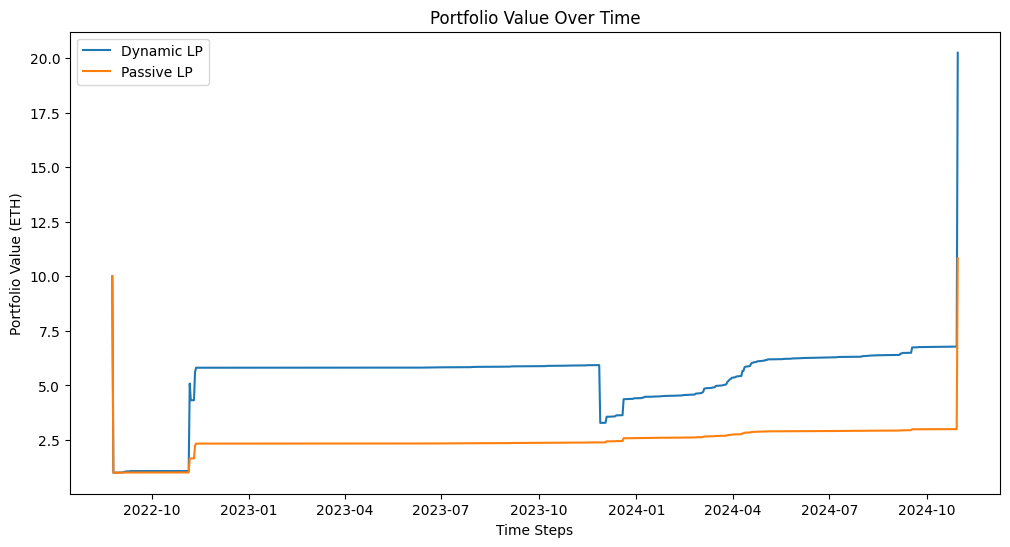

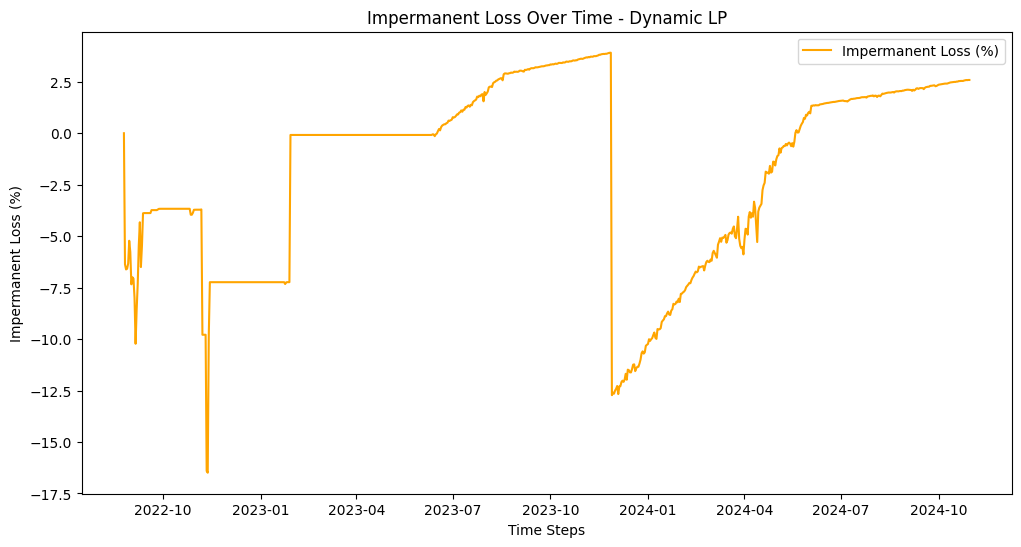

            Starting Portfolio Value  Ending Portfolio Value  Total Fees Earned  Total Return  Annualized Return  Volatility  Sharpe Ratio  Max Drawdown  Impermanent Loss  Rebalances Count  Fee Tier Updates
Dynamic LP                      10.0               20.246938          18.402402      1.024694           0.380787    2.618740      0.145409      0.899914          8.155464               2.0              34.0
Passive LP                      10.0               10.834564           1.997914      0.083456           0.037343    0.783879      0.047639      0.899970          1.163350               0.0               0.0


In [17]:
# ===========================
# 14. Main Execution: Running the Backtest with Singular Scaler
# ===========================

# Define the path to your swap events data
swap_events_file = os.path.join('data', 'wsteth_eth_events.csv')

# Run the backtesting pipeline
metrics_df, dpd = backtest_pipeline(
    swap_events_file,
    use_optuna=True,
    n_optuna_trials=4,
    trained_model='None'
)
print(metrics_df)
